In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product
import gc

from sklearn import preprocessing
import sklearn
# import lightgbm as lgb

In [20]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
sales = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')

In [21]:
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [22]:
sales.head(5)

,date_block_num,shop_id,item_id,item_cnt_day,month
0,0,59,22154,1.0,1
1,0,25,2552,1.0,1
3,0,25,2554,1.0,1
4,0,25,2555,1.0,1
5,0,25,2564,1.0,1


In [25]:
# 1. A file that adds test data (with target set to 0) is added to the sales history
# sales = pd.read_csv('sales_train_test.csv')
# 2. Negative counts are returned objects and they are neglected
sales.drop(sales[sales['item_cnt_day'] < 0].index, inplace=True)
# 3. Negative price is an error and is neglegted
# sales.drop(sales[sales['item_price'] < 0].index, inplace=True)
# 4. Irrelevant columns are deleted
# sales = sales.drop(columns = ['date', 'item_price'])

In [26]:
sales['month'] = sales['date_block_num'].values % 12 + 1

In [27]:
print('There are ' + str(len(items)) + ' different items')
items.head(5)

There are 22170 different items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [28]:
print('There are ' + str(len(item_cats)) + ' different items')
item_cats.head(5)

There are 84 different items


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Text(0, 0.5, 'shop_month_sales')

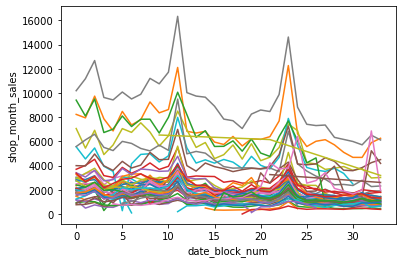

In [29]:
# All Shop sales per month
shopsSales = sales.groupby(['shop_id', 'date_block_num'], as_index=False).agg(shop_month_sales = ('item_cnt_day', 'sum'))
fig = plt.figure()
ax = fig.add_subplot()
for shopId in sales['shop_id'].unique():
    shopSales = shopsSales[shopsSales['shop_id'] == shopId]
    ax.plot(shopSales['date_block_num'], shopSales['shop_month_sales'])
ax.set_xlabel('date_block_num')
ax.set_ylabel('shop_month_sales')

In [30]:
minMonth = 33
closedShopIds = []
for shopId in sales['shop_id'].unique():
    shopMonths = shopsSales[shopsSales['shop_id'] == shopId]['date_block_num'].unique()
    if np.amax(shopMonths) < minMonth:
        closedShopIds.append(shopId)

print('There are ' + str(len(closedShopIds)) + ' closed shops at the last month')

There are 13 closed shops at the last month


In [31]:
# Duplicated shops are merged
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
sales.loc[sales.shop_id == 11, 'shop_id'] = 10

shops = pd.read_csv('../input/salesprediction/shops_extra.csv', sep=';')
shops.head(5)

FileNotFoundError: [Errno 2] No such file or directory: '../input/salesprediction/shops_extra.csv'

In [11]:
# Sold items for each shop and month are added. It is the target column
targetMat = sales.groupby(['shop_id', 'date_block_num', 'item_id'], as_index=False).agg(target = ('item_cnt_day', 'sum'))
featMat = pd.merge(featMat, targetMat, how='left', on=featCols).fillna(0)
featMat
# fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)
# ax[0].hist(featMat['target'], 100)
# ax[0].set_ylabel('occurrencies')
# ax[0].set_xlabel('target')
# ax[1].hist(featMat['target'], 100)
# ax[1].set_ylabel('occurrencies')
# ax[1].set_xlabel('target')
# ax[1].set_ylim([0, 1000])

,shop_id,item_id,date_block_num,target
0,2,7879,0,0.0
1,2,7879,1,0.0
2,2,7879,2,0.0
3,2,7879,3,0.0
4,2,7879,4,0.0
...,...,...,...,...
5461653,59,5002,29,0.0
5461654,59,5002,30,0.0
5461655,59,5002,31,0.0
5461656,59,5002,32,0.0


In [12]:
# Solds are clipped
featMat['target'] = featMat['target'].clip(0, 20).astype(np.int32)
featMat

,shop_id,item_id,date_block_num,target
0,2,7879,0,0
1,2,7879,1,0
2,2,7879,2,0
3,2,7879,3,0
4,2,7879,4,0
...,...,...,...,...
5461653,59,5002,29,0
5461654,59,5002,30,0
5461655,59,5002,31,0
5461656,59,5002,32,0


In [18]:
# Month is added as a feature to capture seasonal trend
featMat['month'] = (featMat['date_block_num'].values % 12 + 1).astype(np.int8)

# Item_category id is added as a feature
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
featMat = pd.merge(featMat, item_category_mapping, how='left', on='item_id').astype(np.int32)
featMat

# Item category features are added
# Categorical features cat_1 and cat_2 are encoded
# le = preprocessing.LabelEncoder()
# cat_1_2 = np.concatenate((item_cats['cat_1'], item_cats['cat_2']))
# le.fit(cat_1_2)
# item_cats['cat_1'] = le.transform(item_cats['cat_1']).astype(np.int32)
# item_cats['cat_2'] = le.transform(item_cats['cat_2']).astype(np.int32)
item_cats.drop(columns=['item_category_name1', 'item_category_name2'], inplace=True)
featMat = pd.merge(featMat, item_cats, how='left', on='item_category_id')

# # Shop features are added
shops['shop_type'] = le.fit_transform(shops['shop_type']).astype(np.int32)
shops.drop(columns=['shop_name', 'City'], inplace=True)
featMat = pd.merge(featMat, shops, how='left', on='shop_id')

# del item_cats
# del items
# del shops
# del sales

C:\Users\okanc\AppData\Local\Temp/ipykernel_6060/1658301024.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'item_category_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  featMat = pd.merge(featMat, item_category_mapping, how='left', on='item_id').astype(np.int32)


KeyError: "['item_category_name1' 'item_category_name2'] not found in axis"

In [15]:
# Previous months are considered
prevCols = ['target', 'shopMonth', 'itemMonth']
lastMonth = np.amax(featMat['date_block_num'].unique())
# Number of previous months to be considered
prevMonths = range(1, 13, 1)

# New columns are added
for prevCol in prevCols:
    for prevMonth in prevMonths:
        featMat[prevCol + '_' + str(prevMonth)] = np.zeros(len(featMat))

for month in range(firstMonth, lastMonth + 1, 1):
    for prevCol in prevCols:
        for prevMonth in prevMonths:        
            featMat.loc[featMat['date_block_num'] == month, prevCol + '_' + str(prevMonth)] = \
            featMat.loc[featMat['date_block_num'] == month - prevMonth, prevCol].values

# Once featMat is filled, not necessary months are droped
featMat.drop(featMat.loc[featMat['date_block_num'] < firstMonth].index, inplace=True)

# Downcasting and cleaning is performed
featMat = downcast_dtypes(featMat)
gc.collect();

featMat.head(15)

KeyError: 'itemMonth'